In [ ]:
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # linux only
%matplotlib inline
import numpy as np
from scipy import spatial

def charclass(png):     # extract character class name from file name
        return png.split('__')[1][:-4]

allpngs = sorted( glob('pngs/*.png') )
h,w,_ = np.array(Image.open(allpngs[0])).shape
h,w
selection = sorted({charclass(png) for png in allpngs}) # ['8','9','minus'] # 

pngs = [png for png in allpngs if charclass(png) in selection]
WT = np.empty( (len(selection), h*w ) )
def get_avg(pngs):
    h,w,_ = np.array(Image.open(pngs[0])).shape
    avg = np.zeros((h,w))
    for png in pngs:
        a = 255 - np.array(Image.open(png))[:,:,0]  # NOTE I AM INVERTING THE IMAGE: MUST DO THIS CONSISTENTLY
        avg += a
    avg /= len(pngs)
    return avg

# Initially set weights for each class as the average over all training images in the class (normalized)
WT = np.empty( (len(selection), h*w ) )
for j,cc in enumerate(selection):
    spngs = [png for png in pngs if charclass(png)==cc]
    WT[j] = get_avg(spngs).reshape(h*w)
    WT[j] /= np.linalg.norm(WT[j])  # make the rows of W **unit** vectors

# Load flattened images as columns of big array X
X = np.empty((h*w,len(pngs)))
for i,png in enumerate(pngs):
    X[:,i] = 255 - np.array(Image.open(png))[:,:,0].reshape(h*w)
tree = spatial.KDTree(X)
# Get the true class numbers of all the images
y = [selection.index(charclass(png)) for png in pngs]  # true classes of images
np.random.choice(y,10)

# Find the predicted class numbers
ypredicted = np.argmax(WT@X, axis=0)

percent_accuracy = 100*(ypredicted==y).sum()/len(pngs)
print('accuracy is {}%'.format(round(percent_accuracy)))

X is the pixel array of the image.

y is the array of each images class

Testing on the training data is not a valid thing to do/ Not a good idea

In [11]:
# a legitimate test on some other images

allpngs = sorted( glob('testpngs/*.png') )
pngs = [png for png in allpngs if charclass(png) in selection]

# Load flattened images as columns of big array X
X = np.empty((h*w,len(pngs)))
for i,png in enumerate(pngs):
    X[:,i] = 255 - np.array(Image.open(png))[:,:,0].reshape(h*w)

# Get the true class numbers of all the images
y = [selection.index(charclass(png)) for png in pngs]  # true classes of images
np.random.choice(y,10)

# Find the predicted class numbers
ypredicted = np.argmax(WT@X, axis=0)

percent_accuracy = 100*(ypredicted==y).sum()/len(pngs)
print('accuracy is {}%'.format(round(percent_accuracy)))

accuracy is 86.0%


$dsigma_j(S)/dsigma_m$  = {   $$sum(e^Sj - e^Sj*e^Sj)/sum^2 = sigma_j(s)(1-sigma_j(s))$$ when j = m,  
$$-e^Sj*e^Sm/sum^2 = -sigma_j(s)*sigma_m(s)$$ when j != m
                         
                         

How to combine the scores for the classes?

A common choice is to form the 'cross-entropy' with the ideal probabilities $$Y^i = e_Y$$

# Gradient Descent

[-0.44318548  2.07125695]


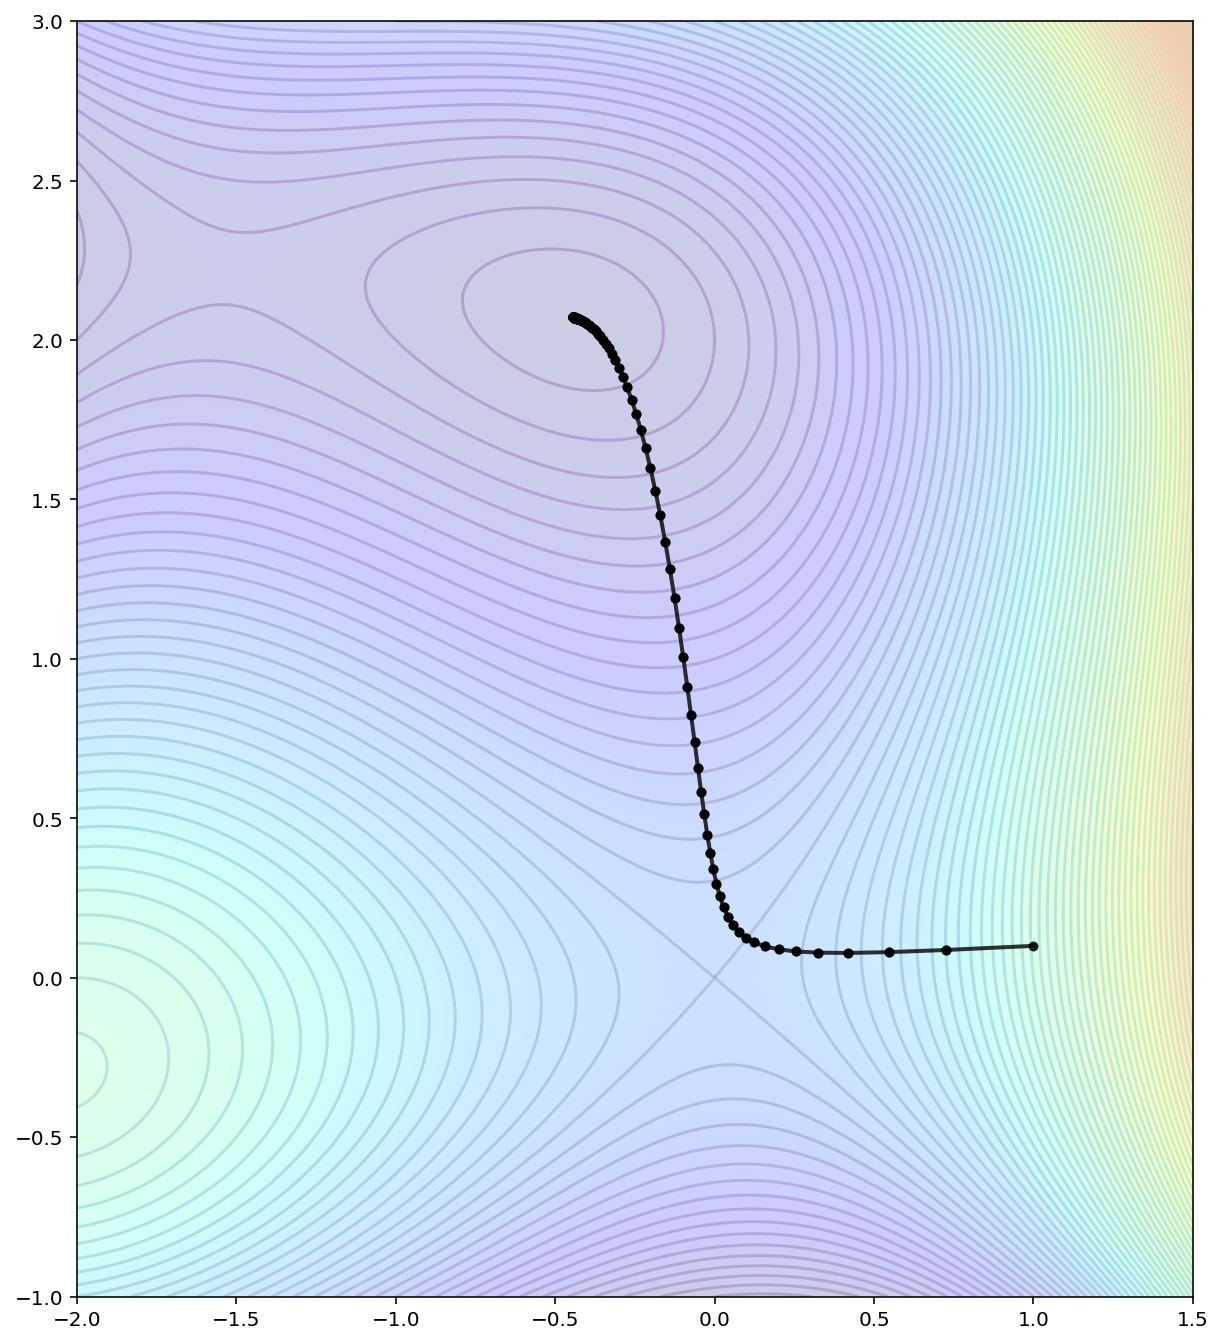

In [10]:
%config InlineBackend.figure_format = 'retina' # linux only
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def mycontourplot(f,xmin,xmax,ymin,ymax):
	x = np.linspace(xmin,xmax,300 )
	y = np.linspace(ymin,ymax,300 )
	X, Y = np.meshgrid(x, y)
	Z = f((X,Y))
	alpha = 0.2 # pale, so we can see the trajectories clearly
	plt.imshow( Z, interpolation='bilinear', origin='lower',
		        cmap='jet',extent=(xmin,xmax,ymin,ymax),alpha=alpha)
	plt.contour( X,Y,f((X,Y)),80,alpha=alpha )

def f(X): 
	x1,x2 = X
	return x1**3 + x2**3 + 3*x1**2 + x1*x2 - 3*x2**2 + 12.

def df(X):
    x1,x2 = X
    ######## need to return gradient here #########
    return np.array([ 3*x1**2 + 0 + 6*x1 + x2 + 0 + 0, 0 + 3*x2**2 + 0 + x1 - 6*x2 + 0])

plt.figure(figsize=(10,12))
plt.subplot(111,aspect=1)
mycontourplot(f,-2.,1.5,-1.,3.)

tol = 1.e-4
startingpoint = [1.,0.1]
stepsizes = [.03] #[.02,0.2,.3] # a.k.a. learning rate
for stepsize in stepsizes:  
	color = 'k' #randomhexcolor(0.4)
	X = np.array(startingpoint)
	for i in range(100):
		gradf = df(X)
		newX = X - stepsize*gradf
		plt.plot( [X[0],newX[0]], [X[1],newX[1]], '.-', lw=2,color=color,markersize=8,alpha=0.8)
		X = newX
		
		if np.linalg.norm(gradf) <= tol: 
			print('gradf small')
			break
	print( X )
#plt.title('gradient descent with various learning rates');